In [0]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.version
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from random import shuffle

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
#TF Version
tf.__version__

#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore",category=FutureWarning)
#    import h5py

num_periods_output = 12 #to predict
num_periods_input=24 #input

No_Of_weeks=12

ALL_Test_Data=[]
ALL_Test_Prediction=[]


## preprocessing

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

def preprocessing(df_,num_features):
    
    if df_.ID[0]!=7 and df_.ID[0]!=8:
        print(df_.Year.unique())
        df=df_[(df_.Year==2017) | (df_.Year==2018)]
        #.isin(years)
        #print(df.loc[df['Year'].isin([2017,2018])])
        print(df.Year.unique())
        print(df.Capacity.unique())
    else:
        df=df_[(df_.Year==2015) | (df_.Year==2016)]
        print(df.Year.unique())
        print(df.Capacity.unique())
    
    '''df_=df[['ID','Occupancy','Year', 'Month', 'Day', 'Hour','Minute', 'Capacity', 
    'DayOfWeek','IsWeekend', 'temperature', 'dew_point', 'humidity', 'wind_speed', 
    'feels_like', 'Status', 'light_snow','snow_shower', 'fog', 
    'thunder', 'mostly_cloudy','rain', 'heavy_rain', 'mist', 'shallow_fog','light_freezing_rain',
    'partly_cloudy', 'haze', 'light_rain', 'rain_shower', 'snow', 'light_snow_shower']]'''
    
    
    
    # select features
    df=df[['ID','Occupancy','Year', 'Month', 'Day', 'Hour','Minute', 
    'DayOfWeek', 'temperature', 'dew_point', 'humidity', 'wind_speed', 'feels_like', 'Status','IsWeekend', 'light_snow','snow_shower', 'fog', 
    'thunder', 'mostly_cloudy','rain', 'heavy_rain', 'mist', 'shallow_fog','light_freezing_rain', 'partly_cloudy',
     'haze', 'light_rain', 'rain_shower', 'snow', 'light_snow_shower','Events_Rugby','Events_Football','Events_Other_Sport','Events_Exhibitions']]
    
    
    ################################################encoding########################
    df['Occupancy'] = pd.to_numeric(df['Occupancy'],errors='coerce')
    df['Occupancy'] = df['Occupancy'].abs()
    
    Status=df.pop('Status')
    df.loc[:,'Status_filling']=(Status=='Filling')*1.0
    df.loc[:,'Status_static']=(Status=='Static')*1.0
    df.loc[:,'Status_emptying']=(Status=='Emptying')*1.0
    
    Number_Of_Features=num_features
    df=df.values
    df = df.astype('float32')
    split=num_periods_output+num_periods_input
    
    ####################### CUT THE PORTION of the data that we are working on 
    
     ########################## SPLITTING FOR TESTING ##########################
    test_len=np.floor(len(df)*0.1)
    mod=test_len%(num_periods_input+num_periods_output)
    #let thelength be divisable by 12
    test_len=int(test_len-mod)
    Test=df[(len(df)-test_len):,:]

    ########################### SPLITTING FOR TRAIN ###########################
    train_cut=int(np.floor(len(df)*0.2))
    new_cutted_df=df[:(len(df)-train_cut),:]
    Start_train_index=int(np.floor(12*24*7*No_Of_weeks))
    print('instances',Start_train_index)
    Train=new_cutted_df[len(new_cutted_df)-Start_train_index:,:]
    train_len=len(Train)
    mod=train_len%(num_periods_input+num_periods_output)
    #let thelength be divisable by 12
    train_len=int(train_len-mod)
    Train=Train[0:train_len,:]
    print('len Train',len(Train))
   
        
    #############################  Normalization on train and validation separatly  #############
     
    ID_Train=Train[:,0]
    Train=np.delete(Train,[0],1)
    #x_batches=x_batches.drop(columns=['ID'], axis=1)
    occ_Train=Train[:,0]
    Train=np.delete(Train,[0],1)
    #x_batches=x_batches.drop(columns=['Occupancy'], axis=1)
    #normalizing data
    Train = Train.astype('float32')
    normalizer = MinMaxScaler().fit(Train)
    #normalizer = Normalizer().fit(Train)
    Train=normalizer.transform(Train)
    
    ID_Train=np.reshape(ID_Train,(len(ID_Train),1))
    occ_Train=np.reshape(occ_Train,(len(occ_Train),1))
    
    Train=np.append(occ_Train, Train, axis=1)
    Train=np.append(ID_Train, Train, axis=1)

    ############################################ TRAIN minibatches ##################################
    
    end=len(Train)
    start=0
    next=0
    x_batches=[]
    y_batches=[]
    
    count=0
    #print('lennnn',len(Train))
    while next+(num_periods_input+num_periods_output)<end:
        next=start+num_periods_input
        x_batches.append(Train[start:next,:])
        y_batches.append(Train[next:next+num_periods_output,1])
        start=start+1
    y_batches=np.asarray(y_batches)
    y_batches = y_batches.reshape(-1, num_periods_output, 1)   
    x_batches=np.asarray(x_batches)
    x_batches = x_batches.reshape(-1, num_periods_input, Number_Of_Features)   
    print('len x_batches ',len(x_batches))
    
    ###########################################TEST#####################################
    
    ID_Test=Test[:,0]
    Test=np.delete(Test,[0],1)
    #X_test=X_test.drop(columns=['ID'], axis=1)
    occ_Test=Test[:,0]
    Test=np.delete(Test,[0],1)
    #X_test=X_test.drop(columns=['Occupancy'], axis=1)
    Test = Test.astype('float32')
    Test=normalizer.transform(Test)
    
    #------------------
    ID_Test=np.reshape(ID_Test,(len(ID_Test),1))
    occ_Test=np.reshape(occ_Test,(len(occ_Test),1))
    
    Test=np.append(occ_Test,Test, axis=1)
    Test=np.append(ID_Test, Test, axis=1)
    
    ############################################ TEST minibatches ##################################
    end_test=len(Test)
    start_test=0
    next_test=0
    x_testbatches=[]
    y_testbatches=[]
    
    
    #print('lennnn',len(Train))
    while next_test+(num_periods_input+num_periods_output)<end_test:
        next_test=start_test+num_periods_input
        x_testbatches.append(Test[start_test:next_test,:])
        y_testbatches.append(Test[next_test:next_test+num_periods_output,1])
        start_test=start_test+1
    y_testbatches=np.asarray(y_testbatches)
    y_testbatches = y_testbatches.reshape(-1, num_periods_output, 1)   
    x_testbatches=np.asarray(x_testbatches)
    x_testbatches = x_testbatches.reshape(-1, num_periods_input, Number_Of_Features) 
    print('len Test',len(Test))
    print('len xTestbatches',len(x_testbatches))
    ######################## Sampling##########################################
    
    #x_batches, y_batches, x_validbatches, y_validbatches, x_testbatches, y_testbatches
    
    return x_batches, y_batches, x_testbatches, y_testbatches

In [0]:

def load_locationfiles(path,loc_id):
    filename=path + '/BN00'+str(loc_id)+'.csv'
    print(filename)
    data_loc=pd.read_csv(filename)
    #print(data_loc.head())
    #mod=len(data_loc)%(num_periods_input+num_periods_output)
    #let thelength be divisable by 12
    #data_loc=data_loc[:len(data_loc)-mod]
    return data_loc

In [0]:
    data_path=r'/content/drive/My Drive/FINAL_DATA_EVENTS'
    #r'/home/shero/Desktop/OurProject/BanesData/Model/occupation_loc/'
    data_All=pd.DataFrame()
    x_batches_Full=[]
    y_batches_Full=[]
    X_Test_Full=[]
    Y_Test_Full=[]
    for loc_id in range(1,9):
        #========
        data=load_locationfiles(data_path,loc_id)
        header=list(data.columns.values)
        data=pd.DataFrame(data,columns=header)
        x_batches, y_batches,X_Test,Y_Test=preprocessing(data,37)
        #===============================
        for element1 in (x_batches):
            x_batches_Full.append(element1)
            
        for element2 in (y_batches):
            y_batches_Full.append(element2)
                        
        for element5 in (X_Test):
            X_Test_Full.append(element5)
            
        for element6 in (Y_Test):
            Y_Test_Full.append(element6)
    #---------------------shuffle minibatches X and Y together-------------------------------------
    print(len(x_batches_Full),'     length of all file : ',len(y_batches_Full))
    combined = list(zip(x_batches_Full, y_batches_Full))
    random.shuffle(combined)
    shuffled_batch_features, shuffled_batch_y = zip(*combined)  

/content/drive/My Drive/FINAL_DATA_EVENTS/BN001.csv
[2014 2015 2016 2017 2018 2019]
[2017 2018]
[628]
instances 24192
len Train 24192
len x_batches  24133
len Test 18288
len xTestbatches 18229
/content/drive/My Drive/FINAL_DATA_EVENTS/BN002.csv
[2014 2015 2016 2017 2018 2019]
[2017 2018]
[1056]
instances 24192
len Train 24192
len x_batches  24133
len Test 19116
len xTestbatches 19057
/content/drive/My Drive/FINAL_DATA_EVENTS/BN003.csv
[2014 2015 2016 2017 2018 2019]
[2017 2018]
[ 860 1500 1160 1360]
instances 24192
len Train 24192
len x_batches  24133
len Test 14832
len xTestbatches 14773
/content/drive/My Drive/FINAL_DATA_EVENTS/BN004.csv
[2015 2016 2017 2018 2019]
[2017 2018]
[698]
instances 24192
len Train 24192
len x_batches  24133
len Test 19656
len xTestbatches 19597
/content/drive/My Drive/FINAL_DATA_EVENTS/BN005.csv
[2014 2015 2016 2017 2018 2019]
[2017 2018]
[1320 1230]
instances 24192
len Train 24192
len x_batches  24133
len Test 14688
len xTestbatches 14629
/content/drive/My

In [0]:
import itertools
import numpy as np
#xgboost part
print(len(x_batches_Full))
All_Training_Instances=[]

Static_Features=[[1,0,0,0,0,0,0,0,1,3,4,6,7,19,9,17,51.3787,-2.3622],[0,1,0,0,0,0,0,0,0,3,9,11,3,29,10,13,51.3843,-2.3686],
                     [0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,51.4113,-2.3869],[0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,51.3902,-2.4059]
                    ,[0,0,0,0,1,0,0,0,0,0,0,4,2,3,0,0,51.3529,-2.3838],[0,0,0,0,0,1,0,0,2,4,8,6,3,39,13,14,51.3842,-2.3590],
                     [0,0,0,0,0,0,1,0,1,1,3,6,6,17,9,7,51.3782,-2.3589],[0,0,0,0,0,0,0,1,1,2,3,6,6,18,9,7,51.3783,-2.3593]]
 
#=============== change each window into Instance =================================
for i in range(0,len(shuffled_batch_features)):
    hold=[]
    temp=[]
    for j in range(0,len(shuffled_batch_features[i])):
      #print(len(hold))
      
      if j==(len(shuffled_batch_features[i])-1):
          index=int(shuffled_batch_features[i][j][0])
          hold=np.concatenate((hold, Static_Features[index-1]), axis=None)
          temp=np.delete(shuffled_batch_features[i][j], [0], axis=0) 
          hold=np.concatenate((hold, temp), axis=None)
          
      else:
          hold=np.concatenate((hold, shuffled_batch_features[i][j][1]), axis=None)
          
    #print(len(hold))
    All_Training_Instances.append(hold)
    

print(len(All_Training_Instances[0]))




193064
77


In [0]:
#=================Testing=====================
All_Testing_Instances=[]

#=============== change each window into Instance =================================
print(len(X_Test_Full))
for i in range(0,len(X_Test_Full)):
  hold=[]
  temp=[]
  for j in range(0,len(X_Test_Full[i])):
       #print(len(hold))
      if j==(len(X_Test_Full[i])-1):
          index=int(X_Test_Full[i][j][0])
          hold=np.concatenate((hold, Static_Features[index-1]), axis=None)
          temp=np.delete(X_Test_Full[i][j], [0], axis=0) 
          hold=np.concatenate((hold, temp), axis=None)
      else:
          hold=np.concatenate((hold, X_Test_Full[i][j][1]), axis=None)
   
  All_Testing_Instances.append(hold)

#prediction=multioutput.predict(All_Testing_Instances)
print(len(All_Testing_Instances[0]))
#===========================calling MultiOutput XGoost=========================
All_Testing_Instances=np.reshape(All_Testing_Instances, (len(All_Testing_Instances),len(All_Testing_Instances[0])))
Y_Test_Full=np.reshape(Y_Test_Full, (len(Y_Test_Full),num_periods_output))

#========== reshape train ==============================
All_Training_Instances=np.reshape(All_Training_Instances, (len(All_Training_Instances),len(All_Training_Instances[0])))
shuffled_batch_y=np.reshape(shuffled_batch_y, (len(shuffled_batch_y),num_periods_output))



print(All_Training_Instances.shape)
model=xgb.XGBRegressor(learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27,silent=False)


multioutput=MultiOutputRegressor(model).fit(All_Training_Instances,shuffled_batch_y)


print('Fitting Done!')

prediction=multioutput.predict(All_Testing_Instances)
#print('prediction ',prediction.shape)
#print('test ',Y_Test_Full.shape)

MSE=np.mean(( prediction- Y_Test_Full)**2)

print('RMSE: ',MSE**0.5)








125096
77
(193064, 77)
[00:50:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[00:54:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:59:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:07:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:12:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:16:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:20:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:24:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:

from matplotlib import pyplot

12
Length of importance 53 Length of Features 56
['Occupancy', 'partly_cloudy', 'Latitude', 'Longitude', 'Hour', 'ID6', 'ID8', 'No_school', 'No_Burial_Ground', 'ID7', 'Minute', 'No_shop', 'light_rain', 'ID5', 'Day', 'No_wedVenues', 'No_GP,No_parks', 'No_Church', 'ID4', 'humidity', 'No_pspace', 'Status0', 'DayOfWeek1', 'DayOfWeek0', 'DayOfWeek3', 'ID1', 'Capacity', 'DayOfWeek4', 'DayOfWeek5', 'haze', 'ID2', 'ID3', 'DayOfWeek2', 'Month', 'fog', 'light_snow', 'temperature', 'feels_like', 'wind_speed', 'thunder', 'snow_shower', 'rain', 'DayOfWeek6', 'heavy_rain', 'shallow_fog', 'Year', 'IsWeekend', 'dew_point', 'Status1', 'Status2', 'mostly_cloudy', 'mist', 'light_freezing_rain']
[0.4425063232580821, 0.013780214911093935, 0.007985106281315288, 0.00719245911265413, 0.006857077717237796, 0.006548367304882656, 0.005479101135279052, 0.003948559766286053, 0.003716547401078666, 0.0034105516970157623, 0.0033128992945421487, 0.0032764892966952175, 0.002790751852444373, 0.00227451088479332, 0.00206

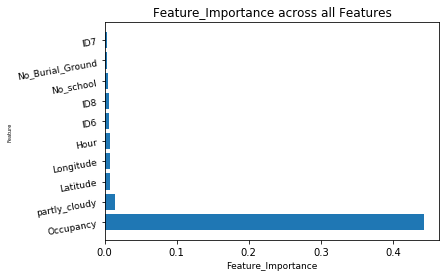

In [0]:
#print(multioutput.feature_importances_)
#multioutput.get_booster().get_score(importance_type='weight')
#print(df)

print(len(multioutput.estimators_))
# 2


# array([ 0.4,  0.6])

Feature_Importance=np.zeros((len(multioutput.estimators_[0].feature_importances_)))
for i in range(0,12):
  Feature_Importance=Feature_Importance+multioutput.estimators_[i].feature_importances_

Feature_Importance=Feature_Importance/num_periods_output
#Feature_Importance= multioutput.estimators_[9].feature_importances_(importance_type='gain')                      
Final_Feature_Importance=Feature_Importance[num_periods_input:]  




#print(Final_Feature_Importance)

#ID,No_Burial_Ground,No_GP,No_parks,No_pspace,No_school,No_shop, No_wedVenues,No_Church

'''
Features=['ID1','ID2','ID3','ID4','ID5','ID6','ID7','ID8','No_Burial_Ground','No_GP,No_parks','No_pspace','No_school','No_shop', 'No_wedVenues',
   'No_Church','Longitude','Latitude','Occupancy','Year', 'Month', 'Day', 'Hour','Minute', 'Capacity', 
    'DayOfWeek0','DayOfWeek1','DayOfWeek2','DayOfWeek3','DayOfWeek4','DayOfWeek5','DayOfWeek6','IsWeekend', 
    'temperature', 'dew_point', 'humidity', 'wind_speed', 'feels_like', 'Status0','Status1','Status2', 'light_snow','snow_shower', 'fog', 
    'thunder', 'mostly_cloudy',
    'rain', 'heavy_rain', 'mist', 'shallow_fog','light_freezing_rain', 'partly_cloudy', 'haze', 'light_rain', 'rain_shower', 'snow', 'light_snow_shower']
'''
Features=['ID1','ID2','ID3','ID4','ID5','ID6','ID7','ID8','No_Burial_Ground','No_GP,No_parks','No_pspace','No_school','No_shop', 'No_wedVenues',
   'No_Church','Longitude','Latitude','Occupancy','Year', 'Month', 'Day', 'Hour','Minute', 'Capacity', 
    'DayOfWeek0','DayOfWeek1','DayOfWeek2','DayOfWeek3','DayOfWeek4','DayOfWeek5','DayOfWeek6','IsWeekend', 
    'temperature', 'dew_point', 'humidity', 'wind_speed', 'feels_like', 'Status0','Status1','Status2', 'light_snow','snow_shower', 'fog', 
    'thunder', 'mostly_cloudy',
    'rain', 'heavy_rain', 'mist', 'shallow_fog','light_freezing_rain', 'partly_cloudy', 'haze', 'light_rain', 'rain_shower', 'snow', 'light_snow_shower']

print('Length of importance',len(Final_Feature_Importance),'Length of Features',len(Features))

from operator import itemgetter
Feature_values,Feature_names=[list(x) for x in zip(*sorted(zip(Final_Feature_Importance, Features), key=itemgetter(0),reverse=True))]

#Feature_values=Feature_values[::-1]
#Feature_names=Feature_names[::-1]


#del Feature_values[0]
#del Feature_values[0]

#del Feature_names[0]
#del Feature_names[0]
print(Feature_names)
################## draw  bar chart =============
index = Feature_names[:10]
print(Feature_values)
plt.barh(index, Feature_values[:10])
plt.ylabel('Feature', fontsize=5)
plt.xlabel('Feature_Importance', fontsize=9)
plt.yticks(index, fontsize=9, rotation=10)
plt.title('Feature_Importance across all Features')
plt.show()
#print(list(data.columns.values))
